In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [3]:
from keras.applications import VGG16

local_weights_path = r'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

conv_base = VGG16(
    weights=local_weights_path,
    include_top=False,
    input_shape=(150, 150, 3)
)

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
# 适用于训练的卷积基模型提取数据特征
import os
import numpy as np

# 设置随机种子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
from keras.utils import ImageDataGenerator

# 数据路径

train_dir = r"C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于计算机视觉\猫狗分类模型\猫狗数据集\dataset\train"
validation_dir = r"C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于计算机视觉\猫狗分类模型\猫狗数据集\dataset\validation"
test_dir = r"C:\Users\Administrator\PycharmProjects\深度学习日常练习项目\python深度学习红书\深度学习用于计算机视觉\猫狗分类模型\猫狗数据集\dataset\test"

In [6]:
datagen = ImageDataGenerator(rescale=1./ 255)
batch_size = 20

# 定义数据特征提取函数
def extract_features(directory,sample_count):
    """
    这个函数用来提取数据特征 使用一个数据生成器来读取目录中的图像，并将它们传递给卷积基模型
    :param directory: 数据所在的文件夹路径
    :param sample_count: 数据样本数量
    :return: 返回提取的特征和对应的标签
    """
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    i = 0
    for inputs_batch, labels_batch in generator:
        batch_size_actual = inputs_batch.shape[0]
        features_batch = conv_base.predict(inputs_batch)

        end_idx = i  * batch_size + batch_size_actual
        features[i* batch_size: end_idx] = features_batch
        labels[i* batch_size:end_idx] = labels_batch
        i += 1
        if end_idx >= sample_count:
            break
    return features,labels

train_features,train_labels = extract_features(train_dir,10000)
validation_features,validation_labels = extract_features(validation_dir,2500)
test_features,test_labels = extract_features(test_dir,6200)

Found 20000 images belonging to 2 classes.
1/1 [==============================] - 0s 14ms/step
Found 5000 images belonging to 2 classes.
1/1 [==============================] - 0s 15ms/step
Found 12461 images belonging to 2 classes.
1/1 [==============================] - 0s 15ms/step


In [7]:
# 将提取的特征展平为一维向量
train_features = np.reshape(train_features,(10000,4*4*512))
validation_features = np.reshape(validation_features,(2500,4*4*512))
test_features = np.reshape(test_features,(6200,4*4*512))

In [8]:
# 使用全连接层进行分类
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping

model = models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

# 编译模型
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss="binary_crossentropy",
              metrics=['accuracy'])

# 训练模型
history = model.fit(
    train_features,train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(validation_features,validation_labels),
    callbacks=[EarlyStopping(monitor='val_loss',patience=3)]
)

Epoch 1/30
313/313 [==============================] - 1s 3ms/step - loss: 0.4459 - accuracy: 0.7858 - val_loss: 0.3077 - val_accuracy: 0.8712
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 0.3013 - accuracy: 0.8704 - val_loss: 0.2674 - val_accuracy: 0.8968
Epoch 3/30
313/313 [==============================] - 1s 2ms/step - loss: 0.2656 - accuracy: 0.8902 - val_loss: 0.2522 - val_accuracy: 0.8980
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 0.2481 - accuracy: 0.8940 - val_loss: 0.2430 - val_accuracy: 0.9020
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 0.2287 - accuracy: 0.9069 - val_loss: 0.2516 - val_accuracy: 0.9036
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 0.2189 - accuracy: 0.9110 - val_loss: 0.2337 - val_accuracy: 0.9156
Epoch 7/30
313/313 [==============================] - 1s 2ms/step - loss: 0.2100 - accuracy: 0.9159 - val_loss: 0.2312 - val_accuracy: 0.9148
Epoch 

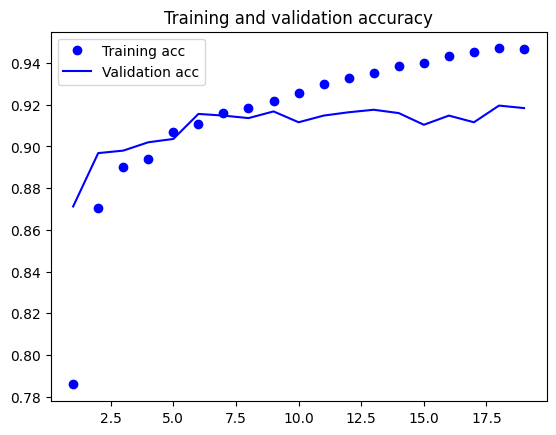

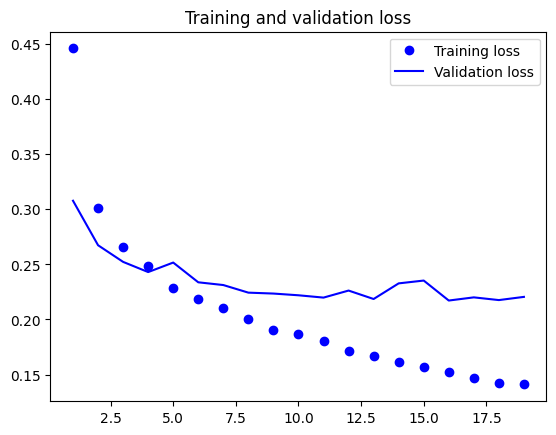

In [9]:
# 绘制结果
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
# 使用测试集进行测试
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [11]:
# 冻结卷积基 防止权重被更新
conv_base.trainable = False

In [13]:
# 利用冻结的卷积基进行端到端训练
from keras.utils import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping

# 创建数据增强生成器
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255) # 增强数据集不可以进行增强

# 创建数据生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

# 编译模型
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss="binary_crossentropy",
    metrics=['accuracy']
)

# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[EarlyStopping(monitor='val_loss',patience=3)]
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 12s 101ms/step - loss: 0.5673 - accuracy: 0.7122 - val_loss: 0.4003 - val_accuracy: 0.8388
Epoch 2/100
100/100 [==============================] - 10s 96ms/step - loss: 0.4527 - accuracy: 0.7975 - val_loss: 0.3541 - val_accuracy: 0.8587
Epoch 3/100
100/100 [==============================] - 10s 99ms/step - loss: 0.4094 - accuracy: 0.8172 - val_loss: 0.3098 - val_accuracy: 0.8612
Epoch 4/100
100/100 [==============================] - 10s 99ms/step - loss: 0.3998 - accuracy: 0.8228 - val_loss: 0.2889 - val_accuracy: 0.8813
Epoch 5/100
100/100 [==============================] - 10s 99ms/step - loss: 0.3779 - accuracy: 0.8359 - val_loss: 0.2969 - val_accuracy: 0.8700
Epoch 6/100
100/100 [==============================] - 10s 97ms/step - loss: 0.3723 - accuracy: 0.8272 - val_loss: 0.2462 - val_accuracy: 0.9050
Epoch 7/100
100/100 [=======================

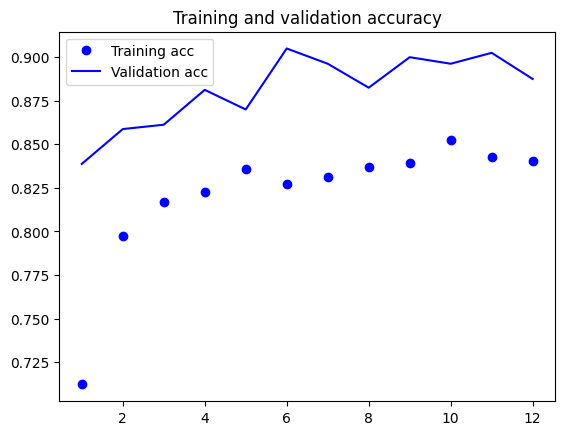

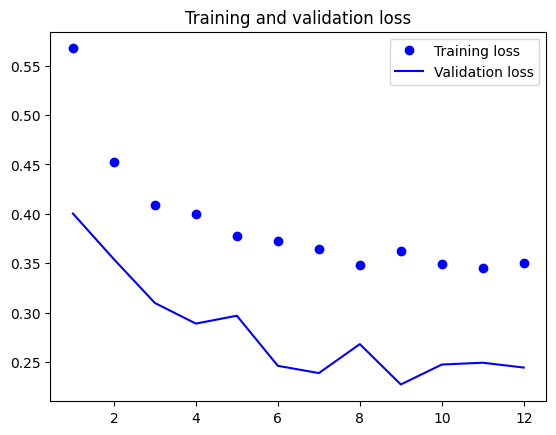

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()